In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

from dynamic_factor import DynamicFactor
from sktime.utils._testing.series import _make_series

%load_ext autoreload
%autoreload 2

In [2]:
y = _make_series(n_timepoints = 50, n_columns= 2)
X = _make_series(n_timepoints = 55, n_columns= 1)

In [3]:
print(y.shape)
print(X.shape)

(50, 2)
(55,)


In [4]:
X_train , X_test = X.iloc[:len(y)] , X.iloc[len(y):]

In [5]:
y.columns = ["GDP","Industrial Production"]

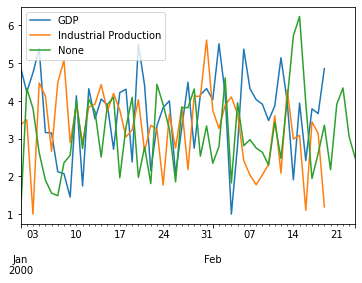

In [6]:
y.plot()
X.plot()
plt.legend()

## Using Statsmodels

To exemplify the behavior of the `predict_interval` function, we first implement it using the DynamicFactor model.

In [7]:
mod = sm.tsa.DynamicFactor(y, exog = X_train, k_factors= 1, factor_order=1);
mod_res = mod.fit();

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14307D+00    |proj g|=  2.41339D-01


 This problem is unconstrained.



At iterate    5    f=  4.17878D+00    |proj g|=  1.95838D+00

At iterate   10    f=  3.75282D+00    |proj g|=  3.03216D-01

At iterate   15    f=  3.70998D+00    |proj g|=  2.32621D-02

At iterate   20    f=  3.58374D+00    |proj g|=  3.53682D-01

At iterate   25    f=  3.46251D+00    |proj g|=  4.56240D-01

At iterate   30    f=  3.24992D+00    |proj g|=  2.14283D-01

At iterate   35    f=  3.17970D+00    |proj g|=  2.08207D-01

At iterate   40    f=  3.11085D+00    |proj g|=  3.03535D-01

At iterate   45    f=  3.07350D+00    |proj g|=  2.24264D-01

At iterate   50    f=  3.03551D+00    |proj g|=  3.33875D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/root/anaconda3/envs/sktime-dev/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
def pred_coverage(steps, coverage) -> pd.DataFrame: 
    #Ensures that the input has the correct type
    if type(coverage) is not list:
        coverage_list = [coverage]
    else:
        coverage_list = coverage

    df_list = []
    for coverage in coverage_list: #Compute the quantile estimates for each coverage

        alpha = -0.5*coverage + 0.5 #Translate coverage to alpha
        orig_df = (mod_res.get_forecast(exog = X_test,steps = steps)\
        .conf_int(alpha = alpha)
        )

        orig_df.rename(columns = {orig_col: orig_col + f" {coverage}" 
        for orig_col in orig_df}, inplace = True)
        df_list.append(orig_df)
    
    #The steps below are necessary to guarantee the correct order of columns
    final_df = pd.concat(df_list , axis = 1)

    mod_var_list = list(map(lambda x: x.replace(' ','') , mod_res.data.ynames))
    
    rename_list = [var_name + " " + str(coverage) + " " +  bound
    for coverage in coverage_list 
    for bound in ["lower", "upper"]
    for var_name in mod_var_list]
    
    final_df.columns = rename_list

    final_ord = [var_name + " " + str(coverage) + " " + bound 
    for var_name in mod_var_list
    for coverage in coverage_list 
    for bound in ["lower", "upper"]]

    final_df = final_df[final_ord]
    cols = [col_name.split(' ') for col_name in final_df.columns]

    final_df_2 = pd.DataFrame(final_df.values, 
    columns = pd.MultiIndex.from_tuples(cols))

    final_columns = [[col_name, str(coverage), bound] 
    for col_name in mod_res.data.ynames
    for coverage in final_df_2.columns.get_level_values(1).unique()
    for bound in final_df_2.columns.get_level_values(2).unique()]

    final_df_3 = pd.DataFrame(final_df_2.values,
    columns = pd.MultiIndex.from_tuples(final_columns))

    return final_df_3

In [9]:
coverage_list = [0.8]

In [10]:
pred_coverage(steps = 5, coverage = coverage_list)

GDP           Industrial Production          
        0.8                             0.8          
      lower     upper                 lower     upper
0  1.073084  5.167634              1.269655  4.446014
1  1.123820  5.257058              1.087781  4.314582
2  1.111980  5.283197              1.013619  4.289633
3  1.016771  5.225279              1.082453  4.406509
4  0.956905  5.202039              1.092530  4.463512

In [11]:
mod_res.predict(exog = X_test, start = 50, end = 54)

,GDP,Industrial Production
2000-02-20,3.120359,2.857835
2000-02-21,3.190439,2.701181
2000-02-22,3.197589,2.651626
2000-02-23,3.121025,2.744481
2000-02-24,3.079472,2.778021


In [12]:
X_test

2000-02-20    2.175820
2000-02-21    3.908622
2000-02-22    4.341409
2000-02-23    3.045283
2000-02-24    2.470367
Freq: D, dtype: float64

## Using the model

In [13]:
model = DynamicFactor()

In [14]:
model.fit(y)

DynamicFactor()

In [15]:
model.predict(fh = [1, 2, 3])

,GDP,Industrial Production
2000-02-20,3.424276,3.125751
2000-02-21,3.423319,3.124878
2000-02-22,3.422362,3.124004


In [16]:
model.predict_interval(fh = [1, 2, 3], coverage= [0.9])

fh is : ForecastingHorizon([1, 2, 3], dtype='int64', is_relative=True)
start is : 50
end is : 52


TypeError: get_prediction() got multiple values for keyword argument 'start'